## Final exam - ada 2018  
Schedule: _30.01.2019 / 08:15 - 11:15_

**Student info:**  
Name: Ruijia WANG  
SCIPER: 223827  
Faculty: SV

### Important notes

- To enhance your experience and your stay are, below are two suggested possible music to listen to while reviewing my code!
 * [Tarkus - Emerson, Lake & Palmer](https://www.youtube.com/watch?v=WKNOlDtZluU)
 * [Mahler: Symphony No. 1 "The Titan"](https://youtu.be/cQFjDBFXN58?t=44)
- Have a nice day and good luck for the remaining copies to grade.

In [178]:
import os
import json
import folium
import sklearn

import csv
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.helper_functions import *

from scipy import stats
from datetime import datetime

from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# (I used this on my computer to make spark work)
import findspark
findspark.init(r'C:\Users\Ruijia\Spark') 

from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()


# The Significant Bang Theory

Attention, ADA students!

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Deadline
Wednesday, January 30th, 2019; 11:15 A.M. (Swiss time)

_For the deadline for extramural exams, see the submission subsection._

## Important notes
* Don't forget to add a textual description of your thought process, the assumptions you made, and your results!
* Please write all your comments in English, and use meaningful variable names in your code.
* As we have seen during the semester, data science is all about multiple iterations on the same dataset. Do not obsess over small details in the beginning, and try to complete as many tasks as possible during the first 2 hours. Then, go back to the obtained results, write meaningful comments, and debug your code if you have found any glaring mistake.
* Fully read the instructions for each question before starting to solve it to avoid misunderstandings, and remember to save your notebook often!
* The exam contains **15 questions organised into 4 tasks**, and is designed for more than 3 hours. **You do not need to solve everything in order to get a 6**, and you have some freedom is choosing the tasks you wish to solve.
* You cannot leave the room in the first and last 15 minutes.
* You can use all the online resources you want except for communication tools (emails, web chats, forums, phone, etc.). We will be monitoring the network for unusual activity.
* Remember, this is not a homework assignment -- no teamwork allowed!

## Submission
* Your file has to be named as "NameSurname_SCIPER.ipynb".
* Make sure you upload your Jupyter Notebook (1 file) to [this](https://goo.gl/forms/7GLvYl94uSOn54jH2) Google form at the end of the exam, with all the cells already evaluated (except for the Spark-related question, Q7). You need to sign in to Google using your EPFL credentials in order to submit the form.
* In case of problems with the form, send your Jupyter Notebook (along with your name and SCIPER number) as a direct message to @ramtin on Mattermost. This is reserved only for those who encounter problems with the submission -- you need to have a reasonable justification for using this back-up.
* You will have until 11:20 (strict deadline) to turn in your submission. **Late submissions will not be accepted.** This deadline is for the students taking the exam at EPFL -- students taking the exam extramurally will have their submission deadline as the starting time of the exam plus 3 hours and 5 minutes.

## Task A: Picking up the shovel (10 points)

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. (5 points) Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
DATA_FOLDER = 'data'
HELPER_FOLDER = 'helper'

In [3]:
# Load the data file
f = open(DATA_FOLDER + '/all_scripts.txt', encoding="utf8")

content = f.readlines()
content = [x.strip() for x in content] 

In [4]:
# Create pd df
all_scripts = pd.DataFrame(content)
all_scripts.rename(columns={0: 'series'}, inplace=True)
all_scripts['episodes']=np.nan
all_scripts['lines']=np.nan
all_scripts.head(5)

,series,episodes,lines
0,>> Series 01 Episode 01 – Pilot Episode,NaN,NaN
1,> A corridor at a sperm bank.,NaN,NaN
2,Sheldon: So if a photon is directed through a ...,NaN,NaN
3,"Leonard: Agreed, what’s your point?",NaN,NaN
4,"Sheldon: There’s no point, I just think it’s a...",NaN,NaN


In [5]:
# See the size of the file
np.shape(all_scripts)

(54329, 3)

In [6]:
# Now separate each >> and > and '' as new columns
for i in range(len(all_scripts)):
    if ">>" in all_scripts['series'][i]:
        current_series = all_scripts['series'][i]
    if ">>" not in all_scripts['series'][i]:
        if ">" in all_scripts['series'][i]:
            current_episodes = all_scripts['series'][i]
            all_scripts['episodes'][i] = all_scripts['series'][i]
            all_scripts['series'][i] = current_series
        if ">" not in all_scripts['series']:
            all_scripts['lines'][i] = all_scripts['series'][i]
            all_scripts['episodes'][i] = current_episodes
            all_scripts['series'][i] = current_series
            
all_scripts

C:\Users\Ruijia\Anaconda2\envs\ada\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ruijia\Anaconda2\envs\ada\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Ruijia\Anaconda2\envs\ada\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Ruijia\Anaconda2\envs\ada\lib\site

,series,episodes,lines
0,>> Series 01 Episode 01 – Pilot Episode,NaN,NaN
1,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,>> Series 01 Episode 01 – Pilot Episode
2,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Sheldon: So if a photon is directed through a ...
3,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Leonard: Agreed, what’s your point?"
4,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Sheldon: There’s no point, I just think it’s a..."
5,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Leonard: Excuse me?
6,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Receptionist: Hang on.
7,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Leonard: One across is Aegean, eight down is N..."
8,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Receptionist: Can I help you?
9,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Leonard: Yes. Um, is this the High IQ sperm bank?"


In [7]:
# count the number of series
all_scripts['series'].unique()

array(['>> Series 01 Episode 01 – Pilot\xa0Episode',
       '>> Series 01 Episode 02 – The Big Bran\xa0Hypothesis',
       '>> Series 01 Episode 03 – The Fuzzy Boots\xa0Corollary',
       '>> Series 01 Episode 04 – The Luminous Fish\xa0Effect',
       '>> Series 01 Episode 05 – The Hamburger\xa0Postulate',
       '>> Series 01 Episode 06 – The Middle Earth\xa0Paradigm',
       '>> Series 01 Episode 07 – The Dumpling\xa0Paradox',
       '>> Series 01 Episode 08 – The Grasshopper\xa0Experiment',
       '>> Series 01 Episode 09 – The Cooper-Hofstadter Polarization',
       '>> Series 01 Episode 10 – The Loobenfeld\xa0Decay',
       '>> Series 01 Episode 11 – The Pancake Batter\xa0Anomaly',
       '>> Series 01 Episode 12 – The Jerusalem\xa0Duality',
       '>> Series 01 Episode 13 – The Bat Jar\xa0Conjecture',
       '>> Series 01 Episode 14 – The Nerdvana\xa0Annihilation',
       '>> Series 01 Episode 15 – The Porkchop\xa0Indeterminacy',
       '>> Series 01 Episode 16 – The Peanut\xa0Re

In [8]:
# There are 10 series
def mask_series(df, str):
    s = pd.Series(df['series'])
    return s.str.startswith('>> Series '+ str)

mask1 = mask_series(all_scripts, '01')
print('In season 1, there is around: ', len(all_scripts[mask1]), 'lines.')

mask2 = mask_series(all_scripts, '02')
print('In season 2, there is around: ', len(all_scripts[mask2]), 'lines.')

mask3 = mask_series(all_scripts, '03')
print('In season 3, there is around: ', len(all_scripts[mask3]), 'lines.')

mask4 = mask_series(all_scripts, '04')
print('In season 4, there is around: ', len(all_scripts[mask4]), 'lines.')

mask5 = mask_series(all_scripts, '05')
print('In season 5, there is around: ', len(all_scripts[mask5]), 'lines.')

mask6 = mask_series(all_scripts, '06')
print('In season 6, there is around: ', len(all_scripts[mask6]), 'lines.')

mask7 = mask_series(all_scripts, '07')
print('In season 7, there is around: ', len(all_scripts[mask7]), 'lines.')

mask8 = mask_series(all_scripts, '08')
print('In season 8, there is around: ', len(all_scripts[mask8]), 'lines.')

mask9 = mask_series(all_scripts, '09')
print('In season 9, there is around: ', len(all_scripts[mask9]), 'lines.')

mask10 = mask_series(all_scripts, '10')
print('In season 10, there is around: ', len(all_scripts[mask10]), 'lines.')

In season 1, there is around:  4313 lines.
In season 2, there is around:  5492 lines.
In season 3, there is around:  5289 lines.
In season 4, there is around:  5907 lines.
In season 5, there is around:  5125 lines.
In season 6, there is around:  5213 lines.
In season 7, there is around:  5701 lines.
In season 8, there is around:  5620 lines.
In season 9, there is around:  5779 lines.
In season 10, there is around:  5890 lines.


**Q2**. (5 points) Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

_Hint: "I know all the recurrent characters because I've watched the entire series five times" is not an acceptable argument, so you need to actually generate the list._

In [9]:
# split at character name
temp = all_scripts.lines.str.split(':', expand=True)
temp.rename(columns={0: 'names', 1: 'lines' }, inplace=True)

name_line = temp[['names','lines']]

all_scripts['names'] = name_line['names']

# Count the appearing names
name_count = all_scripts
name_count['name_count'] = 0.0
name_count = name_count.groupby(['names']).count().reset_index()

# Display name with more than 90 appearance
name_count = name_count[name_count['name_count'] > 90]
name_count[['names', 'name_count']]

,names,name_count
241,Amy,3471
244,Arthur,130
251,Bernadette,2689
252,Bert,95
254,Beverley,162
283,Emily,164
302,Howard,5872
321,Kripke,106
326,Leonard,9829
329,Leslie,116


In [73]:
# Clean data set from names than are not "common"
recurrent_names = pd.Series(name_count['names'])
clean_scripts = all_scripts[all_scripts['names'].isin(recurrent_names)]

clean_scripts.head(10)

,series,episodes,lines,names,name_count
2,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Sheldon: So if a photon is directed through a ...,Sheldon,0.0
3,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Leonard: Agreed, what’s your point?",Leonard,0.0
4,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Sheldon: There’s no point, I just think it’s a...",Sheldon,0.0
5,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Leonard: Excuse me?,Leonard,0.0
7,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Leonard: One across is Aegean, eight down is N...",Leonard,0.0
9,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Leonard: Yes. Um, is this the High IQ sperm bank?",Leonard,0.0
11,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Sheldon: I think this is the place.,Sheldon,0.0
13,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,Leonard: Thank-you. We’ll be right back.,Leonard,0.0
15,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Sheldon: Leonard, I don’t think I can do this.",Sheldon,0.0
16,>> Series 01 Episode 01 – Pilot Episode,> A corridor at a sperm bank.,"Leonard: What, are you kidding? You’re a semi-...",Leonard,0.0


## Task B: Read the ~~stats~~ scripts carefully (30 points)

### Part 1: Don't put the shovel down just yet

**Q3**. (2.5 points) From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [74]:
# Use the helper function to clean the scripts and tokenize it

#import sys
#sys.path.insert(0, '/helpers')
#import helper_functions.py

from string import punctuation

EXCLUDE_CHARS = set(punctuation).union(set('’'))

def simple_tokeniser(text):
    return text.split()

#clean_scripts = clean_scripts.reset_index()

# Too long to compile
#for i in range(len(clean_scripts)):
#    s = str(clean_scripts['lines'][i])
#    clean_scripts['lines'][i] = simple_tokeniser(s)

clean_scripts = clean_scripts.reset_index().drop(['index'], axis=1)
clean_scripts
s = clean_scripts['lines']
s = s.str.split()

In [116]:
# Remove the name of the character saying the line
clean_scripts['lines'] = s
clean_scripts.head(5)

words = pd.Series(clean_scripts['lines'])

for i in range(len(words)):
    words[i] = words[i][1:]
    
clean_scripts['lines'] = words

**Q4**. (5 points) For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [129]:
# count appearence of each words
rows = []
_ = clean_scripts.apply(lambda row: [rows.append([nn]) for nn in row.lines], axis=1)

df_new = pd.DataFrame(rows)

In [138]:
df_new.head(5)
word_list = df_new.rename(columns={0: 'word'})

word_list['word'] = word_list['word'].map(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
word_list['word'] = word_list['word'].str.lower()

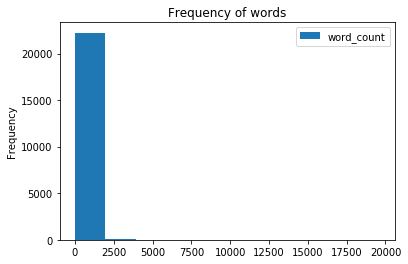

In [152]:
word_list['count'] = 0.0
word_count = word_list.groupby(['word']).count()
word_count = word_count.rename(columns={'count': 'word_count'})

word_count = word_count.sort_values('word_count', ascending=False)

word_count.plot(kind='hist', title='Frequency of words')

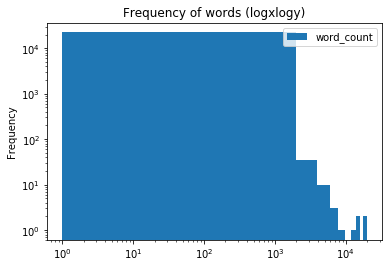

In [151]:
word_count.plot(kind='hist', logx=True, logy=True, title='Frequency of words (logxlogy)')

**Comment:** Most of the words are used few times. Only few words are used a lot. (xaxis: number of words usage, yavis:frequency of words with that usage)

### Part 2: Talkativity
**Q5**. (2.5 points) For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [162]:
# Count the number of word in each lines
# here corpus is wrongly names as it was made in the question above
corpus_scripts = clean_scripts
corpus_scripts = corpus_scripts.drop(['name_count'], axis=1)
corpus_scripts['lines_len'] = 0.0

corpus_scripts['lines_len'] = corpus_scripts['lines'].apply(lambda row: len(row))

#actual count here for nb words per person
corpus_sum = corpus_scripts.groupby(['names']).sum()
corpus_sum = corpus_sum.sort_values('lines_len', ascending=False)

corpus_sum

,lines_len
names,
Sheldon,174896
Leonard,95608
Penny,74247
Howard,64988
Raj,56390
Amy,37381
Bernadette,25744
Stuart,7407
Mrs Cooper,3418


**Answer:** Sheldon is the more talkative character with more than 170'000 words

Bert is the character that speaks the less.

**Q6**. (12.5 points) For each of the recurrent characters, calculate their total number of words uttered per episode (ignoring episodes that the character does not appear in), and calculate a **robust summary statistic** for the word count distribution of each person.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** (2.5 points) What changes do you observe, compared to the analysis in Q5?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** (2.5 points) Why is this analysis an improvement over the previous one, and how could you improve it even further? _Hint: The improvement involves making your unit for word counts even more granular - you can go further down than episodes._

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** (7.5 points) Incorporate that improvement. Do you still see the same results? How **confident** can you be that the "most talkative" person given by this twice improved method is really more talkative than the second most talkative one? _Hint: Read the question again. A good idea would be to use bootstrapping and calculate your summary statistic on each bootstrapped set._

In [160]:
# count words per chara per episodes
episode_word = clean_scripts.drop(['name_count'],axis=1).groupby(['series', 'names']).sum()

# Now that we have the number of words said per episode per character
episode_word.head(20)

lines_len
series                                             names                
>> Series 01 Episode 01 – Pilot Episode            Howard            218
                                                   Leonard          1207
                                                   Man                10
                                                   Penny             554
                                                   Raj                 8
                                                   Sheldon          1205
>> Series 01 Episode 02 – The Big Bran Hypothesis  Howard            242
                                                   Leonard          1023
                                                   Penny             582
                                                   Raj               139
                                                   Sheldon          1031
>> Series 01 Episode 03 – The Fuzzy Boots Corol... Howard            321
                                                   Leonard          1449
                                                   Penny             319
                                                   Raj                70
                                                   Sheldon           722
>> Series 01 Episode 04 – The Luminous Fish Effect Howard             51
                                                   Leonard           451
                                                   Mrs Cooper        781
                                                   Penny             218

In [176]:
# Now lets find the mean words per episode per character
# Need to add the character with lines_len = 0 if not present in the episode?

# episode_word.div(episode_word.groupby(['lines_len']).sum())

episode_word_mean = episode_word.unstack().fillna(0).mean().to_frame()
episode_word_mean = episode_word_mean.rename(columns={0: 'mean_lines_len'})
episode_word_mean = episode_word_mean.sort_values('mean_lines_len', ascending=False)

episode_word_mean

mean_lines_len
          names                       
lines_len Sheldon           807.718615
          Leonard           456.437229
          Penny             354.649351
          Howard            306.753247
          Raj               264.800866
          Amy               176.848485
          Bernadette        123.086580
          Stuart             35.238095
          Mrs Cooper         15.718615
          Beverley            9.004329
          Priya               8.857143
          Wil                 7.372294
          Emily               7.082251
          Mrs Wolowitz        7.082251
          Arthur              6.419913
          Zack                6.367965
          Leslie              5.541126
          Kripke              5.493506
          Man                 5.484848
          Bert                5.021645

In [177]:
episode_word.describe()

,lines_len
count,1663.000000
mean,363.235117
std,269.752968
min,2.000000
25%,168.000000
50%,297.000000
75%,487.500000
max,1633.000000


**i) (2.5 points) What changes do you observe, compared to the analysis in Q5?**

It is still the same three characters that say the most words in total and per episodes (Sheldon, leonard, penny)

**ii) (2.5 points) Why is this analysis an improvement over the previous one, and how could you improve it even further? Hint: The improvement involves making your unit for word counts even more granular - you can go further down than episodes.**

It is an improvement because it indicates which characters says the more per episode, and does not only have one episode where he talks a lot and is never seen again.

Anther better measurement would be to see if the characters says meaningful things and not just only stop words > if the character brings new things to the story or what he says.

A graph of gossips as in Task C would be great.

### Part 3: Obligatory Spark cameo
**Q7**. (7.5 points) Write a Spark script that does the following: Given the raw input file and your list of recurrent characters, create an RDD containing (speaker, dialogue line) rows **only for the recurrent characters** (assume that you already have the list --  no need to calculate it using Spark), and then generate a vectorized bag of words representation for each dialogue line, thus generating an RDD with (speaker, bag of words vector) rows. Then, calculate an aggregated bag of words vector (sum of all vectors) for each person. The final output is therefore an RDD with each of its rows being (speaker, aggregated bag of words vector). For your bag of words vectors, you can use $1\times|V|$ scipy CSR matrices (where $|V|$ is the size of the vocabulary). No filtering of the vocabulary is necessary for this part.

You do not need to run this script, but you do need to use Spark logic and also, the syntax needs to be correct.

## Task C: The Gossip Graph (30 points)

**Note: Only for this task, discard the recurrent characters whose names are not single words, e.g. Mrs. Cooper.**

Let us define _gossip_ as follows: if a dialogue line of character A mentions B by name in a scene that does not involve character B, we say that “A gossips about B” in that line. Multiple mentions of the same person in a single line are counted once, but a character can gossip about several others in the same line. For the sake of simplicity, we only consider gossips where the name of the recurrent character is mentioned as it appears in our list of characters; for example, if someone says "Cooper" and they mean Sheldon, we discard that.

**Q8**. (12.5 points) Create the two following graphs first:

1. (5 points) Create the _familiarity graph_, an undirected weighted graph, in which there is a node for each recurrent character, and an edge between two characters if they appear together in at least one scene. The weight of the edge between them is the number of scenes they appear in together. If an edge exists between two people in the familiarity graph, we say that they "know each other".
2. (7.5 points) Create the _gossip graph_, which is a directed weighted graph, in which there there is a node for each recurrent character, and a directed edge from the node for A to the node for B if A has gossiped about B at least once. The weight of the edge is the number of scenes in which A has gossiped about B.

_Hint: You can create each graph first as an adjacency matrix and then create a networkx graph out of that._

In [ ]:
# Discard names that have a space in it
pure_scripts = clean_scripts[" " not in clean_scripts['names']]

Now, answer the following questions:

**Q9**. (5 points) Sheldon claims that every character in the show is familiar with everyone else through at most one intermediary. Based on the familiarity graph, is this true? If not, at most how many intermediaries are needed?

**Q10**. (5 points) Who is the character through whom the largest number of these indirect familiarities happen? Calculate an appropriate centrality metric on the familiarity graph to answer this question. You can use the package networkx for this section.

**Q11**. (2.5 points) Another claim of Sheldon's is that every recurrent character in the show gossips about all the other recurrent characters. What property of the gossip graph would correspond to this? Does the gossip graph possess that property? If not, then is it the case that for every pair of recurrent characters, at least one gossips about the other? What property would this correspond to?

**Q12**. (5 points) Use the gossip graph and the familiarity graph to figure out if for every pair of recurrent characters, one of them has gossiped about the other if and only if they know each other. Explain your method - the simpler, the better.

## Task D: The Detective's Hat (30 points)

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q13**. (7.5 points) Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

**Q14**. (5 points) Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

**Q15**. (17.5 points) Now, perform singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a **25-dimensional approximation** for both the training and test TF-IDF matrices (you can do this using scikit-learn's **TruncatedSVD** class). Then, train a logistic regression classifier with 10-fold cross-validation (using the scikit-learn **LogisticRegressionCV** class) on the output of the SVD that given a dialogue line, tells you whether it's by Sheldon or by someone else.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** (7.5 points) Report precision, recall and F1-score for both classes (Sheldon and not-Sheldon), as well as accuracy, of your classifier on the training set and the test set. You need to implement the calculation of the evaluation measures (precision, etc.) yourself -- using the scikit-learn functions for them is not allowed.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** (5 points) What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes? Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** (2.5 points) List 10 of the most extreme false positives and 10 of the most extreme false negatives, in terms of the probabilities predicted by the logistic regression model. What are common features of false positives? What about the false negatives?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iv)** (2.5 points) What is the most important feature in the model? What are the 5 most important words in this feature? _Hint: Think of the definition of an SVD, and that you did an SVD on the TF-IDF matrix with dialogue lines as rows and words as columns. You have projected the original data points onto a 25-dimensional subspace -- you need to look at the unit vectors you used for the projection._